# Projet 8 : Segmentation d'Images pour Véhicule Autonome - Notebook de Modélisation

Ce notebook constitue l'espace de travail principal pour le développement des modèles de segmentation d'images dans le cadre du Projet 8 d'OpenClassrooms. Il couvrira les étapes suivantes :
1.  Configuration de l'environnement et des accès.
2.  Chargement et exploration du dataset Cityscapes (un sous-ensemble).
3.  Prétraitement des données, incluant le mapping des classes et la création d'un générateur de données.
4.  Définition, entraînement et évaluation de plusieurs modèles de segmentation.
5.  Analyse des résultats et sélection du meilleur modèle.


## 0. Configuration Initiale et Connexion au Dépôt GitHub

La première étape consiste à configurer l'environnement Colab, à cloner le dépôt GitHub du projet pour assurer le versionnement du code, et à mettre en place les accès nécessaires.

In [8]:
# Cellule d'installation des bibliothèques
!pip install tensorflow opencv-python-headless matplotlib numpy scikit-learn -q
!pip install mlflow pyngrok -q

### 0.1 Clonage du Dépôt GitHub

Le code suivant clone le dépôt GitHub distant contenant le code de ce projet dans l'environnement d'exécution de Google Colab. Cela permet de travailler sur la version la plus à jour du code et de versionner nos modifications. Un token d'accès personnel (PAT) GitHub, stocké dans les secrets de Colab, est utilisé pour l'authentification.

In [1]:
# Accéder au secret
from google.colab import userdata
import os

GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
GITHUB_USER = 'M-Carre'
GITHUB_REPO_NAME = 'OC-autonomous-vehicle-segmentation'
CLONE_DIR = f"/content/{GITHUB_REPO_NAME}"

# Construire l'URL de clonage
clone_url = f"https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/{GITHUB_REPO_NAME}.git"

# Exécuter la commande git clone
# os.system() est parfois plus propre pour ça que ! avec f-strings complexes
os.system(f"git clone {clone_url} {CLONE_DIR}")

# Vérifier
if os.path.exists(CLONE_DIR):
    %cd {CLONE_DIR}
    !ls
    print(f"Dépôt cloné avec succès dans {CLONE_DIR}")
else:
    print(f"Échec du clonage du dépôt dans {CLONE_DIR}")

/content/OC-autonomous-vehicle-segmentation
api  models  notebooks	README.md  reports  src  webapp
Dépôt cloné avec succès dans /content/OC-autonomous-vehicle-segmentation


### 0.2 Configuration des Chemins d'Accès aux Données (Sous-Ensemble Cityscapes)

Pour ce projet, nous utilisons le dataset Cityscapes. Afin de faciliter le développement et de gérer les contraintes de volume de données, nous travaillons initialement avec un **sous-ensemble** de ce dataset. Ce sous-ensemble, contenant à la fois les images (`leftImg8bit`) et les annotations (`gtFine`), a été préalablement décompressé et placé sur Google Drive.

La cellule ci-dessous monte Google Drive et configure les variables de chemin pointant vers les différents répertoires de ce sous-ensemble de données. Il est crucial que la variable `CITYSCAPES_MAIN_ROOT_ON_DRIVE` soit correctement définie pour pointer vers le dossier racine de ce sous-ensemble sur Drive.

In [2]:
# CELLULE DE CONFIGURATION DES DONNÉES (POUR SOUS-ENSEMBLE SUR DRIVE)
# ==============================================================================
import os
IN_COLAB = 'google.colab' in str(get_ipython())

if IN_COLAB:
    from google.colab import drive
    print("Environnement Colab détecté. Montage de Google Drive...")
    drive.mount('/content/drive', force_remount=True)

    # --- MODIFIEZ CE CHEMIN POUR QU'IL POINTE VERS VOTRE SOUS-ENSEMBLE DÉCOMPRESSÉ SUR DRIVE ---
    # Ce dossier doit contenir directement les sous-dossiers 'leftImg8bit' et 'gtFine' de votre sous-ensemble.
    CITYSCAPES_MAIN_ROOT_ON_DRIVE = '/content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_subset' # **ADAPTEZ CE CHEMIN SI NÉCESSAIRE**
    # ------------------------------------------------------------------------------------------

    DATA_ROOT_DIR = CITYSCAPES_MAIN_ROOT_ON_DRIVE
    print(f"Chemin racine des données Cityscapes (sous-ensemble sur Drive) : {DATA_ROOT_DIR}")
    if not os.path.exists(DATA_ROOT_DIR):
        print(f"ATTENTION : Le chemin racine des données {DATA_ROOT_DIR} n'existe pas. Veuillez le vérifier et le corriger.")
        raise FileNotFoundError(f"Le dossier de données racine {DATA_ROOT_DIR} n'a pas été trouvé.")
    else:
        print(f"Le dossier de données racine {DATA_ROOT_DIR} (sous-ensemble) a été trouvé.")
else:
    # Logique pour environnement local (moins pertinent pour l'instant)
    DATA_ROOT_DIR = 'data/cityscapes_subset' # Exemple pour local
    print(f"Environnement local détecté. Chemin des données suggéré : {DATA_ROOT_DIR}")


# Définition des sous-dossiers importants
LEFTIMG8BIT_DIR = os.path.join(DATA_ROOT_DIR, 'leftImg8bit')
GTFINE_DIR = os.path.join(DATA_ROOT_DIR, 'gtFine')

IMG_TRAIN_DIR = os.path.join(LEFTIMG8BIT_DIR, 'train')
MASK_TRAIN_DIR = os.path.join(GTFINE_DIR, 'train')
IMG_VAL_DIR = os.path.join(LEFTIMG8BIT_DIR, 'val')
MASK_VAL_DIR = os.path.join(GTFINE_DIR, 'val')

# Vérifions l'existence de ces sous-dossiers essentiels
essential_paths_to_check = {
    "Dossier racine du sous-ensemble": DATA_ROOT_DIR,
    "Images du sous-ensemble (leftImg8bit)": LEFTIMG8BIT_DIR,
    "Annotations du sous-ensemble (gtFine)": GTFINE_DIR,
    "Images d'entraînement du sous-ensemble": IMG_TRAIN_DIR,
    "Masques d'entraînement du sous-ensemble": MASK_TRAIN_DIR,
    "Images de validation du sous-ensemble": IMG_VAL_DIR,
    "Masques de validation du sous-ensemble": MASK_VAL_DIR
}
all_paths_ok = True
for name, path in essential_paths_to_check.items():
    if not os.path.exists(path):
        print(f"ERREUR : {name} non trouvé à l'emplacement : {path}")
        all_paths_ok = False
    else:
        print(f"Trouvé : {name} à {path}")

if not all_paths_ok:
    raise FileNotFoundError("Un ou plusieurs chemins essentiels pour le sous-ensemble de données Cityscapes n'ont pas été trouvés. "
                          "Veuillez vérifier la variable CITYSCAPES_MAIN_ROOT_ON_DRIVE et la structure de votre sous-ensemble décompressé sur Drive.")
else:
    print("\nTous les chemins de données essentiels pour le sous-ensemble ont été vérifiés avec succès.")

Environnement Colab détecté. Montage de Google Drive...
Mounted at /content/drive
Chemin racine des données Cityscapes (sous-ensemble sur Drive) : /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_subset
Le dossier de données racine /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_subset (sous-ensemble) a été trouvé.
Trouvé : Dossier racine du sous-ensemble à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_subset
Trouvé : Images du sous-ensemble (leftImg8bit) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_subset/leftImg8bit
Trouvé : Annotations du sous-ensemble (gtFine) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_subset/gtFine
Trouvé : Images d'entraînement du sous-ensemble à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_subset/leftImg8bit/train
Trouvé : Masques d'entraînement du sous-ensemble à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_subset/gtFine/train
Trouv

### 0.3 Exploration Initiale des Données : Visualisation d'un Échantillon

Maintenant que les chemins d'accès aux données sont configurés, nous allons charger et visualiser un exemple d'image et son masque d'annotation correspondant (`_gtFine_labelIds.png`). Cette étape est essentielle pour :
1.  Vérifier que les données sont chargées correctement.
2.  Comprendre le format des images et des masques.
3.  Inspecter les valeurs présentes dans les masques d'annotation. Les masques `_gtFine_labelIds.png` contiennent des ID de classe pour chaque pixel, correspondant aux 34 classes fines définies par Cityscapes.

L'objectif est de s'assurer que nous pouvons lire ces données et de confirmer la nature des annotations que nous utiliserons comme vérité terrain (`target`) pour nos modèles. Nous porterons une attention particulière aux valeurs uniques présentes dans le masque chargé, car cela nous donnera un aperçu des classes présentes dans l'image exemple.

Tentative de chargement de l'image : /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_subset/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png
Tentative de chargement du masque (labelIds) : /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_subset/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png

Dimension de l'image : (1024, 2048, 3)
Dimension du masque (labelIds) : (1024, 2048)
Type de données du masque : uint8
Valeurs min/max dans le masque : 0/33
Valeurs uniques dans le masque labelIds de 'aachen_000000_000019': [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]
Nombre de valeurs uniques : 16


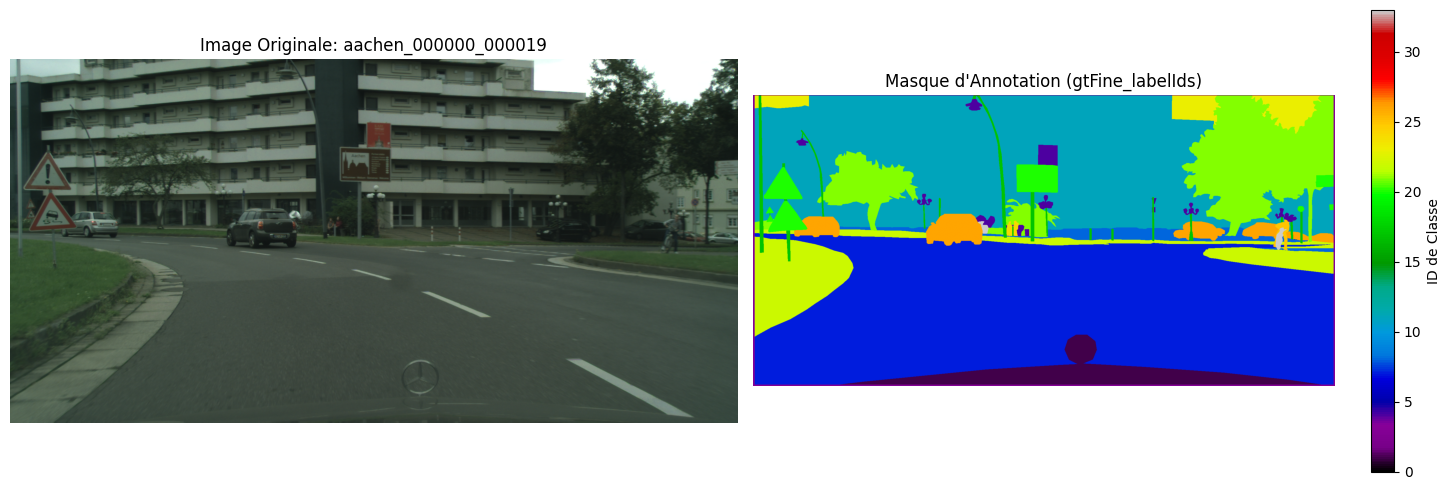

In [4]:
# CELLULE DE VISUALISATION DES IMAGES ET MASQUES

import cv2 # OpenCV pour la lecture et la manipulation d'images
import matplotlib.pyplot as plt # Pour l'affichage des images
import numpy as np # Pour les opérations numériques, notamment sur les tableaux (images)
import os # Pour les opérations sur les chemins de fichiers

# Les variables IMG_TRAIN_DIR, MASK_TRAIN_DIR etc. sont supposées
# être définies par la cellule de configuration des chemins précédente.

try:
    # Vérifier si les dossiers d'entraînement contiennent des données
    if not os.listdir(IMG_TRAIN_DIR):
        raise FileNotFoundError(f"Le dossier d'images d'entraînement {IMG_TRAIN_DIR} est vide ou ne contient pas de sous-dossiers de villes.")

    first_city_in_train_img = os.listdir(IMG_TRAIN_DIR)[0]

    path_to_city_images = os.path.join(IMG_TRAIN_DIR, first_city_in_train_img)
    if not os.listdir(path_to_city_images):
        raise FileNotFoundError(f"Le dossier de la ville {path_to_city_images} pour les images d'entraînement est vide.")

    # Sélectionner dynamiquement un fichier image exemple
    example_image_file_in_city = os.listdir(path_to_city_images)[0]
    # Extraire le nom de base du fichier (sans extension et suffixe _leftImg8bit)
    example_image_name_base = example_image_file_in_city.replace('_leftImg8bit.png', '')

    # Construire les chemins complets pour l'image et son masque d'annotation
    img_path = os.path.join(IMG_TRAIN_DIR, first_city_in_train_img, f'{example_image_name_base}_leftImg8bit.png')
    mask_path_labelIds = os.path.join(MASK_TRAIN_DIR, first_city_in_train_img, f'{example_image_name_base}_gtFine_labelIds.png')

    print(f"Tentative de chargement de l'image : {img_path}")
    print(f"Tentative de chargement du masque (labelIds) : {mask_path_labelIds}")

    # Vérifier l'existence des fichiers avant de tenter de les lire
    if os.path.exists(img_path) and os.path.exists(mask_path_labelIds):
        # Lire l'image avec OpenCV
        img = cv2.imread(img_path)
        # OpenCV lit les images en format BGR (Bleu, Vert, Rouge) par défaut.
        # Matplotlib s'attend à du RGB (Rouge, Vert, Bleu) pour un affichage correct des couleurs.
        # Nous convertissons donc l'ordre des canaux de couleurs.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Lire le masque d'annotation.
        # cv2.IMREAD_UNCHANGED est crucial ici car il assure que le masque est lu
        # tel quel, sans conversion de type ou de nombre de canaux, préservant les ID de classe.
        mask_labelIds = cv2.imread(mask_path_labelIds, cv2.IMREAD_UNCHANGED)

        print(f"\nDimension de l'image : {img.shape}") # Devrait être (hauteur, largeur, 3)
        print(f"Dimension du masque (labelIds) : {mask_labelIds.shape}") # Devrait être (hauteur, largeur)
        print(f"Type de données du masque : {mask_labelIds.dtype}") # Devrait être uint8 pour les ID de classe Cityscapes

        # Analyser les valeurs présentes dans le masque
        unique_ids = np.unique(mask_labelIds)
        print(f"Valeurs min/max dans le masque : {mask_labelIds.min()}/{mask_labelIds.max()}")
        print(f"Valeurs uniques dans le masque labelIds de '{example_image_name_base}': {unique_ids}")
        print(f"Nombre de valeurs uniques : {len(unique_ids)}")

        # Affichage de l'image et du masque
        plt.figure(figsize=(15, 5)) # Taille de la figure pour l'affichage

        plt.subplot(1, 2, 1) # Figure avec 1 ligne, 2 colonnes, ceci est le 1er subplot
        plt.imshow(img)
        plt.title(f'Image Originale: {example_image_name_base}')
        plt.axis('off') # Masquer les axes

        plt.subplot(1, 2, 2) # Ceci est le 2ème subplot
        # 'nipy_spectral' est un colormap qui peut aider à distinguer différentes valeurs numériques.
        # Vous pouvez en essayer d'autres (ex: 'viridis', 'jet', 'tab20').
        plt.imshow(mask_labelIds, cmap='nipy_spectral')
        plt.title(f'Masque d\'Annotation (gtFine_labelIds)')
        plt.colorbar(label='ID de Classe') # Ajoute une légende pour les couleurs/valeurs
        plt.axis('off') # Masquer les axes

        plt.tight_layout() # Ajuste automatiquement les subplots pour un meilleur rendu
        plt.show() # Affiche la figure
    else:
        print("ERREUR : Un des fichiers exemples (image ou masque labelIds) n'a pas été trouvé.")
        if not os.path.exists(img_path): print(f"Image non trouvée à l'emplacement : {img_path}")
        if not os.path.exists(mask_path_labelIds): print(f"Masque labelIds non trouvé à l'emplacement : {mask_path_labelIds}")

except FileNotFoundError as e:
    print(f"ERREUR lors de la recherche de fichiers : {e}")
    print("Veuillez vérifier que les dossiers d'entraînement/validation dans votre sous-ensemble contiennent bien des sous-dossiers de villes, et que ces derniers contiennent des images/masques.")
except IndexError:
    print("ERREUR : Impossible de lister des fichiers dans les dossiers d'images/masques.")
    print("Cela peut se produire si les dossiers de villes sont vides ou si la structure du dataset n'est pas celle attendue.")
except Exception as e:
    print(f"Une erreur inattendue est survenue lors de la visualisation : {e}")

L'exécution de la cellule précédente a permis de charger et visualiser avec succès une image du sous-ensemble Cityscapes (`aachen_000000_000019`) et son masque d'annotation `_gtFine_labelIds.png`.

**Observations Clés :**
- **Dimensions Confirmées :** L'image (1024x2048x3) et le masque (1024x2048) ont les dimensions attendues.
- **Type de Données du Masque :** `uint8`, ce qui est correct pour les ID de classe.
- **Contenu du Masque :** Pour l'échantillon visualisé, les ID de classe varient de 0 à 33, avec **16 classes uniques** présentes.

Ces résultats confirment que nous accédons correctement aux données brutes. La présence de multiples ID de classes (jusqu'à 34 possibles au total dans le dataset) dans les masques `_labelIds.png` est la base pour notre tâche de segmentation. La prochaine étape logique impliquerait le mapping de ces classes fines vers les 8 catégories cibles du projet, mais avant cela, nous allons configurer notre outil de suivi d'expériences, MLflow.

### 0.4 Initialisation de MLflow avec Serveur de Tracking Distant via ngrok

Pour suivre et gérer nos expérimentations de modèles de manière robuste et persistante, nous allons maintenant configurer **MLflow**. Au lieu d'utiliser le stockage local temporaire de Colab, nous mettrons en place un **serveur de tracking MLflow accessible à distance** :
1.  Le **serveur MLflow** tournera dans notre environnement Colab.
2.  Ses données (métadonnées et artefacts des expériences) seront stockées de manière **persistante sur Google Drive**.
3.  **ngrok** créera un tunnel public sécurisé vers ce serveur, nous donnant une URL pour accéder à l'interface utilisateur (UI) de MLflow depuis n'importe quel navigateur. Le token d'authentification ngrok (`NGROK_AUTH_TOKEN`) est requis et doit être configuré dans les secrets Colab.

La cellule suivante installe les dépendances nécessaires, lance le serveur MLflow, le connecte à ngrok, et effectue un test de logging pour valider la configuration.

In [9]:
# CELLULE POUR LANCER MLFLOW SERVER AVEC NGROK (VERSION SIMPLIFIÉE)

import mlflow
import os
from google.colab import userdata, drive
import subprocess
import time
from pyngrok import ngrok, conf

# --- 1. Configuration ---
DRIVE_MLFLOW_PARENT_DIR = '/content/drive/MyDrive/Colab Notebooks/OC/P8/mlflow_tracking_persistent' # Adaptez
MLFLOW_BACKEND_STORE_URI = f"sqlite:///{os.path.join(DRIVE_MLFLOW_PARENT_DIR, 'mlflow.db')}"
MLFLOW_DEFAULT_ARTIFACT_ROOT = os.path.join(DRIVE_MLFLOW_PARENT_DIR, 'artifacts')
MLFLOW_PORT = 5000

os.makedirs(os.path.dirname(MLFLOW_BACKEND_STORE_URI.replace("sqlite:///", "")), exist_ok=True)
os.makedirs(MLFLOW_DEFAULT_ARTIFACT_ROOT, exist_ok=True)
print(f"Données MLflow seront stockées dans : {DRIVE_MLFLOW_PARENT_DIR}")

# --- 2. ngrok ---
try:
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    if not NGROK_AUTH_TOKEN: raise ValueError("Token ngrok (NGROK_AUTH_TOKEN) manquant dans les secrets.")
    conf.get_default().auth_token = NGROK_AUTH_TOKEN
    # Arrêter les tunnels précédents pour éviter les conflits
    try: ngrok.kill()
    except: pass # Ignorer si aucun tunnel n'est actif
    print("Configuration ngrok OK.")
except Exception as e:
    print(f"ERREUR ngrok config : {e}")
    raise

# --- 3. Serveur MLflow ---
# S'assurer d'être dans un répertoire approprié
GIT_REPO_PATH_IN_COLAB = '/content/OC-autonomous-vehicle-segmentation'
if os.path.exists(GIT_REPO_PATH_IN_COLAB): os.chdir(GIT_REPO_PATH_IN_COLAB)
else: os.chdir('/content/')

print(f"Lancement du serveur MLflow depuis {os.getcwd()}...")
# Tuer les instances précédentes
os.system("pkill -f 'mlflow server'")
time.sleep(1)

mlflow_server_command = [
    "mlflow", "server",
    "--backend-store-uri", MLFLOW_BACKEND_STORE_URI,
    "--default-artifact-root", MLFLOW_DEFAULT_ARTIFACT_ROOT,
    "--host", "0.0.0.0", "--port", str(MLFLOW_PORT)
]
# Lance le serveur en arrière-plan, redirige stdout/stderr vers /dev/null pour un output propre
mlflow_server_process = subprocess.Popen(mlflow_server_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
print(f"Serveur MLflow démarré (PID: {mlflow_server_process.pid}). Attente (5s)...")
time.sleep(5) # Laisser le temps de démarrer

if mlflow_server_process.poll() is not None:
    raise RuntimeError("Échec du démarrage du serveur MLflow. Vérifiez la configuration.")
print("Serveur MLflow semble opérationnel.")

# --- 4. Exposer avec ngrok ---
try:
    public_url = ngrok.connect(MLFLOW_PORT, "http").public_url
    print(f"✅ UI MLflow accessible publiquement à : {public_url}")
except Exception as e:
    print(f"ERREUR lancement ngrok tunnel : {e}")
    mlflow_server_process.terminate(); mlflow_server_process.wait() # Tuer le serveur si ngrok échoue
    raise

# --- 5. Configurer et Tester MLflow Client ---
mlflow.set_tracking_uri(f"http://localhost:{MLFLOW_PORT}") # Le client logue vers le serveur local, ngrok fait le pont
print(f"URI de tracking MLflow configurée sur : {mlflow.get_tracking_uri()}")

try:
    with mlflow.start_run(run_name="TestServeurDistantSimplifié"):
        mlflow.log_param("test_param_simple", 123)
        mlflow.log_metric("test_metric_simple", 0.123)
    print(f"🎉 Run de test MLflow ('TestServeurDistantSimplifié') logguée avec succès sur {public_url}")
except Exception as e:
    print(f"ERREUR lors du test de logging MLflow : {e}")

# Conservez la variable `mlflow_server_process` si vous voulez l'arrêter proprement plus tard
# et `public_url` pour la déconnexion ngrok.

Données MLflow seront stockées dans : /content/drive/MyDrive/Colab Notebooks/OC/P8/mlflow_tracking_persistent
Configuration ngrok OK.
Lancement du serveur MLflow depuis /content/OC-autonomous-vehicle-segmentation...
Serveur MLflow démarré (PID: 45453). Attente (5s)...
Serveur MLflow semble opérationnel.
✅ UI MLflow accessible publiquement à : https://7b79-35-247-13-48.ngrok-free.app
URI de tracking MLflow configurée sur : http://localhost:5000


🏃 View run TestServeurDistantSimplifié at: http://localhost:5000/#/experiments/0/runs/551ad4d2da4a4fbeaef272f14ffaead1
🧪 View experiment at: http://localhost:5000/#/experiments/0
🎉 Run de test MLflow ('TestServeurDistantSimplifié') logguée avec succès sur https://7b79-35-247-13-48.ngrok-free.app


In [10]:
# Cellule pour arrêter ngrok et le serveur MLflow (exécuter quand vous avez fini)
from pyngrok import ngrok

print("Arrêt des tunnels ngrok...")
try:
    ngrok.kill() # Tue tous les tunnels ngrok de cette session
    print("Tunnels ngrok arrêtés.")
except Exception as e:
    print(f"Erreur lors de l'arrêt de ngrok : {e}")

# Tuer le processus serveur MLflow (si vous avez stocké son PID)
# Si vous n'avez pas le PID, 'pkill' est une option plus brutale mais fonctionne souvent en Colab
print("\nTentative d'arrêt du serveur MLflow...")
os.system("pkill -f 'mlflow server'")
print("Commande pkill pour le serveur MLflow envoyée.")
# Note: mlflow_server_process.terminate() ne fonctionnera que si la variable
# mlflow_server_process de la cellule de démarrage est toujours accessible et que le processus est le même.

Arrêt des tunnels ngrok...
Tunnels ngrok arrêtés.

Tentative d'arrêt du serveur MLflow...
Commande pkill pour le serveur MLflow envoyée.


## 1. Préparation du Générateur de Données et Conception des Modèles

Avec la configuration initiale et l'outil de suivi d'expériences (MLflow) en place, nous entrons maintenant dans la **Phase 1**. L'objectif principal ici est de préparer nos données Cityscapes pour qu'elles puissent être efficacement utilisées par nos modèles de segmentation d'images. Cela implique deux étapes majeures :

1.  **Création d'un Générateur de Données (Data Generator)** : Nous allons développer une classe Python personnalisée, héritant de `tf.keras.utils.Sequence`. Ce générateur sera responsable du chargement des images et des masques, du **mapping des ~34 classes fines de Cityscapes vers nos 8 catégories cibles**, du redimensionnement, de la normalisation, de l'augmentation des données, et de la fourniture des données par lots (batches) au modèle.
2.  **Conception Initiale des Modèles de Segmentation** : Parallèlement, nous définirons les architectures de base pour nos modèles de segmentation (par exemple, un U-Net simple et un U-Net avec un encodeur pré-entraîné), ainsi que les métriques d'évaluation et les fonctions de perte appropriées.

Commençons par la tâche la plus critique : le **développement du générateur de données**, en nous concentrant d'abord sur le chargement des données et le mapping des classes.

### 1.1 Définition du Mapping des Classes : des 34 Classes Cityscapes aux 8 Catégories Cibles

La première étape cruciale dans la préparation de nos données est de traduire les annotations fines fournies par Cityscapes (environ 34 classes distinctes, identifiées par des `id` spécifiques) vers les **8 catégories principales** requises par l'énoncé du projet. Ces 8 catégories sont : `flat`, `human`, `vehicle`, `construction`, `object`, `nature`, `sky`, et `void`.

Pour réaliser ce mapping de manière propre et réutilisable, nous avons :
1.  Créé un fichier Python (`cityscapes_labels.py`) contenant les définitions officielles des labels Cityscapes (nom, `id`, `category`, `ignoreInEval`, etc.). Ce fichier est stocké sur Google Drive et sera versionné avec notre projet.
2.  Importé ces définitions dans notre notebook.
3.  Défini un dictionnaire de correspondance (`category_mapping_to_new_id`) qui associe chaque nom de catégorie Cityscapes pertinent à un nouvel ID cible (de 0 à 7 pour nos 8 catégories).
4.  Généré un dictionnaire final, `id_to_target_id_mapping`, qui mappe chaque `id` original de Cityscapes vers :
    *   L'un de nos nouveaux ID cibles (0-7) si la classe Cityscapes appartient à l'une de nos 8 catégories principales et n'est pas explicitement marquée comme "à ignorer pour l'évaluation" (sauf si sa catégorie est 'void').
    *   Une valeur spéciale (`IGNORE_VALUE_FOR_LOSS = 255`) pour toutes les autres classes (celles à ignorer, celles non pertinentes, ou 'license plate').


In [11]:
# CELLULE POUR DÉFINIR LE MAPPING DES CLASSES (VERSION PROPRE AVEC IMPORT)

import numpy as np
import os
import sys # Pour manipuler le chemin d'importation

# --- Étape 1: Ajouter le chemin du dossier contenant 'cityscapes_labels.py' au sys.path ---
# Ceci est nécessaire pour que Python puisse trouver votre module personnalisé.

# Chemin vers le DOSSIER PARENT de cityscapes_labels.py sur Drive
# Si cityscapes_labels.py est dans '/content/drive/MyDrive/Colab Notebooks/OC/P8/src/cityscapes_labels.py',
# alors le dossier à ajouter à sys.path est '/content/drive/MyDrive/Colab Notebooks/OC/P8/src'

# Supposons que labels_file_path_on_drive de l'étape précédente était:
# labels_file_path_on_drive = '/content/drive/MyDrive/Colab Notebooks/OC/P8/src/cityscapes_labels.py'
# Alors le module_dir est :
module_dir_on_drive = '/content/drive/MyDrive/Colab Notebooks/OC/P8/src' # ADAPTEZ CECI

if module_dir_on_drive not in sys.path:
    sys.path.append(module_dir_on_drive)
    print(f"Ajouté '{module_dir_on_drive}' à sys.path")

# --- Étape 2: Importer la liste 'labels' depuis votre module ---
try:
    from cityscapes_labels import labels as labels_cityscapes # 'labels' est le nom de la variable dans votre .py
    print("Importation de 'labels_cityscapes' depuis 'cityscapes_labels.py' réussie.")
except ImportError as e:
    print(f"ERREUR d'importation : {e}")
    print("Vérifiez que 'cityscapes_labels.py' existe à l'emplacement attendu et que le chemin a été correctement ajouté à sys.path.")
    print(f"Contenu de sys.path: {sys.path}")
    raise # Arrêter ici si l'importation échoue

# --- Étape 3: Définir votre logique de mapping (identique à avant) ---

# Vos 8 catégories cibles et leurs nouveaux IDs (0 à 7)
category_mapping_to_new_id = {
    'flat': 0,
    'human': 1,
    'vehicle': 2,
    'construction': 3,
    'object': 4,
    'nature': 5,
    'sky': 6,
    'void': 7  # Pour 'ground', 'dynamic', 'static' et autres classes de la catégorie 'void' de Cityscapes
}
NUM_TARGET_CLASSES = 8
IGNORE_VALUE_FOR_LOSS = 255 # Valeur pour les pixels non mappés à 0-7 ou explicitement ignorés

# Création du dictionnaire de mapping: cityscapes_id -> new_target_id
id_to_target_id_mapping = {}

for label_info in labels_cityscapes: # Utilise maintenant la variable importée
    cityscapes_id = label_info.id
    cityscapes_category = label_info.category
    ignore_in_eval = label_info.ignoreInEval

    if cityscapes_id == -1: # 'license plate'
        id_to_target_id_mapping[cityscapes_id] = IGNORE_VALUE_FOR_LOSS
        continue

    # Si la classe Cityscapes est marquée 'ignoreInEval=True' ET que sa catégorie N'EST PAS 'void',
    # alors on l'ignore, même si sa catégorie parente est l'une de nos 8.
    if ignore_in_eval and cityscapes_category != 'void':
        id_to_target_id_mapping[cityscapes_id] = IGNORE_VALUE_FOR_LOSS
    # Sinon, si la catégorie de Cityscapes est dans notre mapping direct (flat, human, ..., void)
    elif cityscapes_category in category_mapping_to_new_id:
        id_to_target_id_mapping[cityscapes_id] = category_mapping_to_new_id[cityscapes_category]
    # Pour toutes les autres classes (celles dont la catégorie n'est pas dans notre liste des 8,
    # ou celles explicitement 'unlabeled', 'ego vehicle', etc. qui sont 'void' mais aussi 'ignoreInEval')
    # elles seront implicitement ignorées si leur catégorie n'est pas 'void' et qu'elles sont 'ignoreInEval',
    # ou si leur catégorie n'est simplement pas dans notre mapping des 8.
    # Pour plus de robustesse, on peut ajouter un 'else' pour les mapper à IGNORE_VALUE_FOR_LOSS.
    else:
        # Ce cas devrait attraper les classes comme 'unlabeled', 'ego vehicle', etc.
        # qui sont 'void' et 'ignoreInEval=True', ou toute autre classe non explicitement gérée.
        # Si leur catégorie est 'void', elles sont déjà gérées ci-dessus.
        # Si leur catégorie n'est pas 'void' et pas dans notre mapping, alors ignore.
        # print(f"Info: Classe Cityscapes '{label_info.name}' (ID: {cityscapes_id}, Cat: {cityscapes_category}) non explicitement mappée à 0-7, sera IGNORÉE.")
        id_to_target_id_mapping[cityscapes_id] = IGNORE_VALUE_FOR_LOSS


# Afficher le mapping pour vérification (identique à avant)
print("\n--- Mapping de cityscapes_id vers new_target_id (0-7 pour les 8 catégories, 255 pour ignore) ---")
all_cs_ids = sorted(list(set([lbl.id for lbl in labels_cityscapes]))) # Obtenir tous les ID uniques de Cityscapes

for cs_id in all_cs_ids:
    target_id = id_to_target_id_mapping.get(cs_id, "NON DÉFINI DANS LE MAPPING !") # Utiliser .get pour éviter les erreurs si un ID manque

    original_label_name = "N/A"
    original_category = "N/A"
    ignore_flag = "N/A"
    for lbl in labels_cityscapes:
        if lbl.id == cs_id:
            original_label_name = lbl.name
            original_category = lbl.category
            ignore_flag = lbl.ignoreInEval
            break
    print(f"Cityscapes ID: {cs_id:>2} (Nom: {original_label_name:<22}, Cat: {original_category:<14}, IgnoreEval: {str(ignore_flag):<5})  => Mappé à ID Cible: {target_id}")

# Afficher les ID Cityscapes qui n'ont pas été explicitement mappés (devrait être vide si bien fait)
# Cela aide à s'assurer que tous les ID de 0 à 33 sont couverts.
print("\n--- Vérification des ID Cityscapes non couverts par le mapping (devrait être vide) ---")
mapped_cs_ids = set(id_to_target_id_mapping.keys())
for i in range(34): # ID de 0 à 33
    if i not in mapped_cs_ids:
        print(f"ATTENTION : L'ID Cityscapes {i} n'a pas d'entrée dans id_to_target_id_mapping !")
if -1 not in mapped_cs_ids:
    print(f"ATTENTION : L'ID Cityscapes -1 n'a pas d'entrée dans id_to_target_id_mapping !")

print(f"\nDictionnaire de mapping final ('id_to_target_id_mapping') contient {len(id_to_target_id_mapping)} entrées.")

Ajouté '/content/drive/MyDrive/Colab Notebooks/OC/P8/src' à sys.path
Importation de 'labels_cityscapes' depuis 'cityscapes_labels.py' réussie.

--- Mapping de cityscapes_id vers new_target_id (0-7 pour les 8 catégories, 255 pour ignore) ---
Cityscapes ID: -1 (Nom: license plate         , Cat: vehicle       , IgnoreEval: True )  => Mappé à ID Cible: 255
Cityscapes ID:  0 (Nom: unlabeled             , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  1 (Nom: ego vehicle           , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  2 (Nom: rectification border  , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  3 (Nom: out of roi            , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  4 (Nom: static                , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  5 (Nom: dynamic               , Cat: void          , IgnoreEval: True

Le dictionnaire final contient 35 entrées, couvrant tous les ID Cityscapes de -1 à 33. Ce mapping est maintenant prêt à être utilisé dans notre générateur de données pour transformer les masques d'annotation bruts.

# Script GitHub

In [ ]:
# ==============================================================================
# SCRIPT DE SYNCHRONISATION (DRIVE -> REPO LOCAL) ET PUSH VERS GITHUB (V3 avec Debug LS)
# ==============================================================================
import os
import shutil
from google.colab import userdata

# --- Configuration des Chemins et Fichiers ---
PROJECT_BASE_ON_DRIVE = '/content/drive/MyDrive/Colab Notebooks/OC/P8'
GIT_REPO_PATH_IN_COLAB = '/content/OC-autonomous-vehicle-segmentation'
GIT_BRANCH_NAME = 'main'

# Assurez-vous que cette liste correspond aux dossiers sur Drive où vous avez mis les .gitkeep
ITEMS_TO_SYNC = [
    "notebooks",
    "src",
    "api",
    "webapp",
    "reports",
    "models",
    "scripts",    # Assurez-vous que ce dossier existe sur Drive avec un .gitkeep si vous le listez
    ".gitignore", # Si vous le gérez sur Drive
    "README.md"   # Si vous le gérez sur Drive
]
# ------------------------------------------------------------------------------

def sync_and_push_to_github_v3():
    print("### 1. VÉRIFICATION DES CHEMINS ###")
    if not os.path.exists(PROJECT_BASE_ON_DRIVE):
        print(f"ERREUR : Le dossier source sur Drive '{PROJECT_BASE_ON_DRIVE}' n'existe pas.")
        return
    if not os.path.exists(GIT_REPO_PATH_IN_COLAB):
        print(f"ERREUR : Le dossier du dépôt Git cloné '{GIT_REPO_PATH_IN_COLAB}' n'existe pas.")
        return
    print(f"Source du projet sur Drive : {PROJECT_BASE_ON_DRIVE}")
    print(f"Dépôt Git local dans Colab : {GIT_REPO_PATH_IN_COLAB}")

    print("\n### 2. NAVIGATION VERS LE RÉPERTOIRE DU DÉPÔT GIT LOCAL ###")
    try:
        os.chdir(GIT_REPO_PATH_IN_COLAB)
        print(f"Changé de répertoire vers : {os.getcwd()}")
    except FileNotFoundError:
        print(f"ERREUR CRITIQUE : Impossible de naviguer vers le répertoire du dépôt Git '{GIT_REPO_PATH_IN_COLAB}'.")
        return

    print("\n### 3. MISE À JOUR DEPUIS LE DÉPÔT DISTANT (GIT PULL) ###")
    # Configurez l'identité Git si ce n'est pas déjà fait dans la session
    !git config --global user.email "carre.mathis@proton.me"
    !git config --global user.name "M-Carre"

    print(f"Tentative de 'git pull origin {GIT_BRANCH_NAME}' --rebase...")
    # Utilisation de --rebase pour maintenir un historique propre
    pull_result = os.system(f"git pull origin {GIT_BRANCH_NAME} --rebase")
    if pull_result != 0:
        print(f"AVERTISSEMENT : 'git pull --rebase' a rencontré un problème (code {pull_result}). Vérifiez les messages.")
        print("Si des conflits sont signalés, ils devront être résolus manuellement avant de continuer.")
        # Pour un script automatisé, il est difficile de gérer les conflits de rebase.
        # Une alternative serait de faire un 'git merge' si le rebase échoue,
        # ou simplement d'arrêter et de demander une intervention manuelle.
        # Pour l'instant, nous continuons, mais soyez conscient des problèmes potentiels.
    else:
        print("'git pull --rebase' terminé avec succès (ou pas de changements distants/conflits).")

    print("\n### 4. SYNCHRONISATION DES FICHIERS (DRIVE -> REPO LOCAL) ###")
    synced_item_count = 0
    for item_rel_path in ITEMS_TO_SYNC:
        source_item_abs_path = os.path.join(PROJECT_BASE_ON_DRIVE, item_rel_path)
        dest_item_abs_path = os.path.join(os.getcwd(), item_rel_path)

        if not os.path.exists(source_item_abs_path):
            # Si l'élément est listé dans ITEMS_TO_SYNC mais n'existe pas sur Drive, on l'ignore.
            # On pourrait aussi choisir de supprimer l'élément correspondant dans le repo local
            # si on veut une synchronisation stricte, mais c'est plus risqué.
            print(f"AVERTISSEMENT : L'élément source '{source_item_abs_path}' n'existe pas sur Drive. Ignoré pour la copie.")
            continue

        os.makedirs(os.path.dirname(dest_item_abs_path), exist_ok=True)

        if os.path.isdir(source_item_abs_path):
            if os.path.exists(dest_item_abs_path) and os.path.isdir(dest_item_abs_path): # S'assurer que c'est bien un dossier
                print(f"   Suppression du dossier de destination existant : {dest_item_abs_path}")
                shutil.rmtree(dest_item_abs_path)
            elif os.path.exists(dest_item_abs_path) and not os.path.isdir(dest_item_abs_path): # Si un fichier existe avec le même nom
                print(f"   Suppression du fichier de destination existant (au lieu d'un dossier) : {dest_item_abs_path}")
                os.remove(dest_item_abs_path)

            print(f"   Copie du dossier : '{source_item_abs_path}' vers '{dest_item_abs_path}'")
            shutil.copytree(source_item_abs_path, dest_item_abs_path)
            synced_item_count += 1
        elif os.path.isfile(source_item_abs_path):
            print(f"   Copie du fichier : '{source_item_abs_path}' vers '{dest_item_abs_path}'")
            shutil.copy2(source_item_abs_path, dest_item_abs_path)
            synced_item_count += 1

    if synced_item_count > 0: print(f"\n{synced_item_count} élément(s) listé(s) dans ITEMS_TO_SYNC et existant sur Drive ont été synchronisé(s).")
    else: print("\nAucun élément de ITEMS_TO_SYNC n'a été trouvé sur Drive pour la synchronisation ou la liste ITEMS_TO_SYNC est vide.")

    print("\n### 4b. INSPECTION DU CONTENU LOCAL APRÈS SYNCHRO ###")
    print(f"Contenu actuel de {os.getcwd()}:")
    !ls -A # -A pour montrer les fichiers cachés comme .gitkeep et .gitignore, mais pas . et ..

    # Liste des dossiers à inspecter (basée sur une structure typique)
    folders_to_inspect = ["src", "api", "webapp", "models", "reports", "scripts", "notebooks"]
    for folder in folders_to_inspect:
        folder_path_local = os.path.join(os.getcwd(), folder)
        if os.path.exists(folder_path_local) and os.path.isdir(folder_path_local):
            print(f"\nContenu de ./{folder}/ :")
            # Utiliser find pour lister tous les fichiers, y compris dans les sous-dossiers, et montrer les .gitkeep
            # os.system(f"find {folder} -print -type d -empty -delete") # Pourrait supprimer les dossiers vides non désirés
            os.system(f"ls -A {folder_path_local}") # Simple ls -A du contenu du dossier
        elif os.path.exists(folder_path_local):
             print(f"\nATTENTION: ./{folder} existe mais n'est pas un dossier.")
        # else:
        #     print(f"\nLe dossier ./{folder}/ n'existe pas localement après la synchronisation.")


    print("\n### 5. OPÉRATIONS GIT (ADD, COMMIT, PUSH) ###")
    print("\n--- Statut Git (après synchronisation et pull) ---")
    !git status

    print("\nAjout de tous les changements au staging area (git add .)...")
    !git add .

    print("\n--- Statut Git (après 'git add .') ---")
    !git status --short # Version courte pour voir les fichiers staged

    commit_message = input("\nEntrez votre message de commit (laissez vide pour annuler le commit/push) : ")

    if not commit_message:
        print("\nMessage de commit vide. Opération de commit et push annulée.")
        print("\n--- Statut Git Actuel (changements non commités) ---")
        !git status
        return

    print(f"\nCommit des changements avec le message : '{commit_message}'")
    os.environ['GIT_COMMIT_MESSAGE'] = commit_message
    !git commit -m "$GIT_COMMIT_MESSAGE"
    del os.environ['GIT_COMMIT_MESSAGE']

    print(f"\nPush des changements vers la branche '{GIT_BRANCH_NAME}' sur GitHub...")
    push_result = os.system(f"git push origin {GIT_BRANCH_NAME}")
    if push_result == 0:
        print("\n--- Opération de synchronisation, commit et push terminée avec succès. ---")
    else:
        print(f"ERREUR : 'git push' a échoué avec le code {push_result}. Vérifiez les messages ci-dessus.")

    print("Vérifiez votre dépôt sur GitHub pour confirmer les changements.")

# --- Exécution de la fonction ---
sync_and_push_to_github_v3()